# Imports

In [1]:
import os
from dotenv import load_dotenv
from typing import Optional, List
from datetime import datetime

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

import whisper
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

/opt/anaconda3/envs/remember_me_env/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


# Environment setup

In [2]:
def set_env():
    # Load environment variables from .env file
    load_dotenv()
    # Retrieve the OpenAI API key from environment variables
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    # Ensure the key is correctly loaded
    if not OPENAI_API_KEY:
        raise ValueError("No OPENAI_API_KEY set for the Django project")
    # Set the OpenAI API key in the environment variables
    os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

set_env()

## OpenAI prompt

## Extraction prompt

Here we will create a prompt that will extract the tasks and their corresponding dates from a message (string)

In [3]:

def extract_tasks(message: str):
    class Task(BaseModel):
        """Information about a task."""
        task: Optional[str] = Field(
            default=None, 
            description="The task itself."
        )
        date: Optional[datetime] = Field(
            default=None, 
            description=f"The datetime for when this task is due knowing that current datetime is {datetime.now()}"
        )
        is_show_request: bool = Field(
            default=None, 
            description="If the message requests to show the task list"
        )

    class Data(BaseModel):
        """Extracted data about tasks."""

        tasks: List[Task]

    ext_and_sum_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an expert extraction algorithm. "
                "Only extract relevant information from the text. "
                "If you do not know the value of an attribute asked to extract, "
                "return null for the attribute's value.",
            ),
            ("human", "{text}"),
        ]
    )


    model = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-0125")

    extract_runnable = ext_and_sum_prompt | model.with_structured_output(schema=Data)
    response = extract_runnable.invoke({"text": message}).dict()
    print(response)
    return response



## Message processing

Here we will define a function that will process the messages that are received... Extracting the tasks and dates, and channeling them to the correct outputs.

In [4]:
def print_tasks(tasks):
    print("--> Tasks:")
    if not tasks:
        print("There are currently no tasks.")
    for task in tasks:
        print(f"- {task['task']} --> due by {task['date']}")

In [5]:
def process_message(message, tasks):
    is_print_tasks = False
    extraction = extract_tasks(message)
    for task in extraction["tasks"]:
        if task["task"] is not None:
            if task["date"] is None:
                # send message asking for date
                pass
            task_info = {
                "task": task["task"],
                "date": task["date"]
            }
            tasks.append(task_info)
            is_print_tasks = True
        else:
            
            if task["is_show_request"]:
                is_print_tasks = True
            else:
                print("Sorry, understand requests to add tasks to the task list or requests to show the task list.")
    if is_print_tasks:
        print_tasks(tasks)
                


# Whisper

Here we will test the whisper models and evaluate which offers best performance while keeping low latency times

## Loading models

First we will load the models

In [21]:
# Load the Whisper models
model_tiny = {
    "model": whisper.load_model("tiny"),
    "name": "tiny"
}
model_base = {
    "model": whisper.load_model("base"),
    "name": "base"
}
model_small = {
    "model": whisper.load_model("small"),
    "name": "small"
}
model_medium = {
    "model": whisper.load_model("medium"),
    "name": "medium"
}
model_large = {
    "model": whisper.load_model("large"),
    "name": "large"
}

models = [model_tiny, model_base, model_small, model_medium, model_large]

number_of_models = len(models)

## Running models

Now we will iterate through the test audios and save the execution time necessary for the different whisper models to output the transcription and save the transcription itself.

In [22]:
number_of_audios = len(os.listdir("audios"))

results = {}

for model in models:
    for audio in os.listdir("audios"):
        print(f"###### Transcribing {audio} with {model['name']} model... ######")
        start_time = time.time()
        result = model["model"].transcribe(f"audios/{audio}", fp16=False)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time: {execution_time}")
        message = result["text"]
        print(f"Transcription: {message}")
        result = {
            "model_name": model["name"],
            "audio_name": audio,
            "transcription": message,
            "execution_time": execution_time    
        }
        results[(model["name"], audio)] = result
        print(f"Items left to process: {number_of_models * number_of_audios - len(results)}")
        print("---------------------------------------------------")


###### Transcribing 8.m4a with tiny model... ######
Execution time: 4.945495843887329
Transcription:  pcept% em troandır em trozinha tigo de advice que vai ser nossa vida
Items left to process: 169
---------------------------------------------------
###### Transcribing 9.m4a with tiny model... ######
Execution time: 1.9802680015563965
Transcription:  Um, um, um, um box e a pita que eu digo fica meira para o fazente, não? Pocinto.
Items left to process: 168
---------------------------------------------------
###### Transcribing 00000009-AUDIO-2024-06-21-00-18-50.opus with tiny model... ######
Execution time: 3.0934581756591797
Transcription:  O Moss não adici e pé...
Items left to process: 167
---------------------------------------------------
###### Transcribing 00000003-AUDIO-2024-06-21-00-17-59.opus with tiny model... ######
Execution time: 0.8831050395965576
Transcription:  e mostra o minha lista de tarefas.
Items left to process: 166
-----------------------------------------------

## Test case labeling

Here we will manually label the correct transcriptions for each audio

In [23]:
audios = {}
audio1 = {
    "audio_name": "1.m4a",
    "transcription": "Oi, tudo bem? Como é que tá indo?"
}
audios[audio1["audio_name"]] = audio1
audio2 = {
    "audio_name": "2.m4a",
    "transcription": "Noh, hoje tá um frio de doer o dente em!"
}
audios[audio2["audio_name"]] = audio2
audio3 = {
    "audio_name": "00000003-AUDIO-2024-06-21-00-17-59.opus",
    "transcription": "Me mostra a minha lista de tarefas."
}
audios[audio3["audio_name"]] = audio3
audio4 = {
    "audio_name": "3.m4a",
    "transcription": "Você pode adicionar uma tarefa na minha lista de afazeres pra ligar pra Olívia amanhã as 10 da tarde, por favor? 10 da tarde não, 10 da manhã."
}
audios[audio4["audio_name"]] = audio4
audio5 = {
    "audio_name": "00000004-AUDIO-2024-06-21-00-18-02.opus",
    "transcription": "Me mostra minha lista de tarefas."
}
audios[audio5["audio_name"]] = audio5
audio6 = {
    "audio_name": "4.m4a",
    "transcription": "Agora vou aferir a sua pressão arterial sistólica."
}
audios[audio6["audio_name"]] = audio6
audio7 = {
    "audio_name": "00000005-AUDIO-2024-06-21-00-18-07.opus",
    "transcription": "Quais são as minhas tarefas?"
}
audios[audio7["audio_name"]] = audio7
audio8 = {
    "audio_name": "5.m4a",
    "transcription": "Me lembra de fazer meu diário de campo às duas horas amanhã."
}
audios[audio8["audio_name"]] = audio8
audio9 = {
    "audio_name": "00000006-AUDIO-2024-06-21-00-18-11.opus",
    "transcription": "Quais são as coisas que eu preciso fazer?"
}
audios[audio9["audio_name"]] = audio9
audio10 = {
    "audio_name": "6.m4a",
    "transcription": "Aqui tem marmita suficiente pra dois dias só."
}
audios[audio10["audio_name"]] = audio10
audio11 = {
    "audio_name": "00000007-AUDIO-2024-06-21-00-18-18.opus",
    "transcription": "Me mostra a minha lista de tarefas."
}
audios[audio11["audio_name"]] = audio11
audio12 = {
    "audio_name": "7.m4a",
    "transcription": "Ter que fazer, porque não vai dar suficiente, entendeu?"
}
audios[audio12["audio_name"]] = audio12
audio13 = {
    "audio_name": "00000008-AUDIO-2024-06-21-00-18-29.opus",
    "transcription": "Quais são as coisas que eu preciso fazer?"
}
audios[audio13["audio_name"]] = audio13
audio14 = {
    "audio_name": "8.m4a",
    "transcription": "Que que você pensa em fazer, tipo assim, da casa?"
}
audios[audio14["audio_name"]] = audio14
audio15 = {
    "audio_name": "00000009-AUDIO-2024-06-21-00-18-50.opus",
    "transcription": "Mostra minha lista de tarefas."
}
audios[audio15["audio_name"]] = audio15
audio16 = {
    "audio_name": "9.m4a",
    "transcription": "O banheiro sim, o box e a pia e tal. Porque é o dia que fica melhor pra eu fazer, entendeu. Pode ser então?"
}
audios[audio16["audio_name"]] = audio16
audio17 = {
    "audio_name": "00000010-AUDIO-2024-06-21-00-18-55.opus",
    "transcription": "Quais são as tarefas que eu preciso fazer?"
}
audios[audio17["audio_name"]] = audio17
audio18 = {
    "audio_name": "10.m4a",
    "transcription": "Você tá gravando? Pra ele ir escrevendo?"
}
audios[audio18["audio_name"]] = audio18
audio19 = {
    "audio_name": "11.m4a",
    "transcription": "Me lembra de tirar o lixo e levar lá pra fora."
}
audios[audio19["audio_name"]] = audio19
audio20 = {
    "audio_name": "00000012-AUDIO-2024-06-21-00-19-49.opus",
    "transcription": "Adiciona uma tarefa pra eu levar o lixo fora amanhã às 8 horas da noite."
}
audios[audio20["audio_name"]] = audio20
audio21 = {
    "audio_name": "12.m4a",
    "transcription": "Nossa que saco isso em, pelo amor de Deus."
}
audios[audio21["audio_name"]] = audio21
audio22 = {
    "audio_name": "00000013-AUDIO-2024-06-21-00-20-07.opus",
    "transcription": "Adiciona uma tarefa pra eu levar o lixo lá pra fora amanhã a noite às 8 da noite."
}
audios[audio22["audio_name"]] = audio22
audio23 = {
    "audio_name": "13.m4a",
    "transcription": "Adiciona uma tarefa pra poder lembrar de criar o novo website e depois também adicionar a chave de API do site."
}
audios[audio23["audio_name"]] = audio23
audio24 = {
    "audio_name": "00000014-AUDIO-2024-06-21-00-20-34.opus",
    "transcription": "Me lembra de fazer o trabalho de aprendizado de máquina até o dia 23 de julho."
}
audios[audio24["audio_name"]] = audio24
audio25 = {
    "audio_name": "14.m4a",
    "transcription": "Me mostra as tarefas que eu tenho no momento."
}
audios[audio25["audio_name"]] = audio25
audio26 = {
    "audio_name": "00000015-AUDIO-2024-06-21-00-20-43.opus",
    "transcription": "Me lembra de fazer o trabalho de aprendizado de máquina até o dia 23 de julho."
}
audios[audio26["audio_name"]] = audio26
audio27 = {
    "audio_name": "15.m4a",
    "transcription": "Me mostra as tarefas que eu tenho no momento."
}
audios[audio27["audio_name"]] = audio27
audio28 = {
    "audio_name": "00000016-AUDIO-2024-06-21-00-21-14.opus",
    "transcription": "Adiciona uma tarefa pra eu levar o lixo fora amanhã às 8 da noite."
}
audios[audio28["audio_name"]] = audio28
audio29 = {
    "audio_name": "16.m4a",
    "transcription": "Me mostra a minha lista de tarefas."
}
audios[audio29["audio_name"]] = audio29
audio30 = {
    "audio_name": "00000017-AUDIO-2024-06-21-00-21-23.opus",
    "transcription": "Adiciona uma tarefa pra eu levar o lixo fora amanhã às 8 da noite."
}
audios[audio30["audio_name"]] = audio30
audio31 = {
    "audio_name": "17.m4a",
    "transcription": "Me mostra a minha lista de tarefas."
}
audios[audio31["audio_name"]] = audio31
audio32 = {
    "audio_name": "00000018-AUDIO-2024-06-21-00-22-20.opus",
    "transcription": "Me lembra de fazer o trabalho de aprendizado de máquina até o dia 23 de julho."
}
audios[audio32["audio_name"]] = audio32
audio33 = {
    "audio_name": "00000019-AUDIO-2024-06-21-00-22-27.opus",
    "transcription": "Me lembra de fazer o trabalho de aprendizado de máquina até o dia 23 de julho."
}
audios[audio33["audio_name"]] = audio33
audio34 = {
    "audio_name": "AUDIO-2024-06-21-12-06-46.m4a",
    "transcription": "Adicione a tarefa de falar que amo Daniel segunda-feira que vem 3 horas da tarde."
}
audios[audio34["audio_name"]] = audio34

## Analyzing test results

Here we will compare the transcription outputted by each model for each audio and compare it to the correclty manually labeled transcription using cosine similarity.

Then we will add all of this to a pandas dataframe that will include:
- The model name
- The audio name
- The cosine similarity
- The execution time (latency) for the output
- The transcription outputted by the model
- The correctly manually labeled transcription

In [24]:
vectorizer = TfidfVectorizer()

final_results = []

for audio in os.listdir("audios"):
    for model in models:
        model_name = model["name"]
        model_transcription = results[(model_name, audio)]["transcription"]
        correct_transcription = audios[audio]["transcription"]
        execution_time = results[(model_name, audio)]["execution_time"]

        # Fit and transform the strings to get the TF-IDF vectors
        tfidf_matrix = vectorizer.fit_transform([model_transcription, correct_transcription])

        # Compute the cosine similarity between the two vectors
        cosine_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])[0][0]
        
        final_results.append([model_name, audio, cosine_sim, execution_time, model_transcription, correct_transcription])

df = pd.DataFrame(final_results, columns=["model_name", "audio_name", "cosine_sim", "execution_time", "model_transcription", "correct_transcription"])
df.to_csv("2results.csv", index=False)

df


,model_name,audio_name,cosine_sim,execution_time,model_transcription,correct_transcription
0,tiny,8.m4a,0.185289,4.945496,pcept% em troandır em trozinha tigo de advice...,"Que que você pensa em fazer, tipo assim, da casa?"
1,base,8.m4a,0.450176,2.824880,E você pensa em fazer tipo se invacar a casa.,"Que que você pensa em fazer, tipo assim, da casa?"
2,small,8.m4a,0.871366,6.298497,"O que você pensa em fazer? Tipo assim, ir da ...","Que que você pensa em fazer, tipo assim, da casa?"
3,medium,8.m4a,0.962250,23.045385,"O que você pensa em fazer? Tipo assim, da casa.","Que que você pensa em fazer, tipo assim, da casa?"
4,large,8.m4a,0.962250,50.161851,"O que você pensa em fazer? Tipo assim, da casa?","Que que você pensa em fazer, tipo assim, da casa?"
...,...,...,...,...,...,...
165,tiny,5.m4a,0.649888,0.810669,Me lembra de fazer meu diário de campo as luz...,Me lembra de fazer meu diário de campo às duas...
166,base,5.m4a,0.592249,1.457829,Me lembra de fazer meu dia de campo às 2h a m...,Me lembra de fazer meu diário de campo às duas...
167,small,5.m4a,0.868094,3.980101,Me lembra de fazer meu dia de campo às duas h...,Me lembra de fazer meu diário de campo às duas...
168,medium,5.m4a,0.752320,15.615685,Me lembre de fazer meu dia de campo às duas h...,Me lembra de fazer meu diário de campo às duas...


Here we will plot the results comparing the execution times and the cosine similarities according to model type:

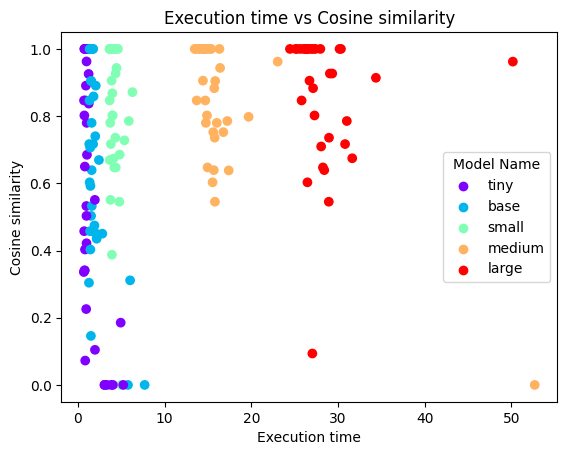

In [25]:
model_names = df["model_name"].unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(model_names)))
color_map = dict(zip(model_names, colors))

# Assign colors to each point based on the model name
point_colors = df["model_name"].map(color_map)

plt.scatter(df["execution_time"], df["cosine_sim"], c=point_colors)
plt.xlabel("Execution time")
plt.ylabel("Cosine similarity")
plt.title("Execution time vs Cosine similarity")
# Create a legend
for model_name, color in color_map.items():
    plt.scatter([], [], c=[color], label=model_name)
plt.legend(title="Model Name")
plt.show()

In [37]:
# get the row that has the highest execution time for each model
max_execution_time = df.groupby("model_name")["execution_time"].idxmax()
df.loc[max_execution_time]

,model_name,audio_name,cosine_sim,execution_time,model_transcription,correct_transcription
86,base,00000017-AUDIO-2024-06-21-00-21-23.opus,0.000000,7.708469,Morac coveti nu stiu anklecot.,Adiciona uma tarefa pra eu levar o lixo fora a...
4,large,8.m4a,0.962250,50.161851,"O que você pensa em fazer? Tipo assim, da casa?","Que que você pensa em fazer, tipo assim, da casa?"
53,medium,10.m4a,0.000000,52.684103,זהİ,Você tá gravando? Pra ele ir escrevendo?
2,small,8.m4a,0.871366,6.298497,"O que você pensa em fazer? Tipo assim, ir da ...","Que que você pensa em fazer, tipo assim, da casa?"
85,tiny,00000017-AUDIO-2024-06-21-00-21-23.opus,0.000000,5.239223,Au reast și nu am matarefă irre travail,Adiciona uma tarefa pra eu levar o lixo fora a...


In [ ]:
model = whisper.load_model("large")
audio_path = "ivan.m4a"
output = model.transcribe(audio_path, fp16=False)
message = output["text"]

print(message)

tasks = []
process_message(message, tasks)

{'tasks': [{'task': 'Falar que amo Daniel', 'date': datetime.datetime(2024, 6, 24, 15, 0), 'is_show_request': None}]}
--> Tasks:
- Falar que amo Daniel --> due by 2024-06-24 15:00:00
